# LLSQ Fit
Use background corrected reference spectra to fit an unknown. 

In [1]:
using NeXLSpectrum
using DataFrames, Gadfly, CSV
using LinearAlgebra

┌ Info: Loading Gadfly support into NeXLSpectrum.
└ @ NeXLSpectrum C:\Users\nritchie\.julia\dev\NeXLSpectrum\src\gadflysupport.jl:564


Load the unknown spectrum and the reference spectra.  Plot them.

In [2]:
path = joinpath(@__DIR__,"K309")
unk = loadspectrum(joinpath(path, "K309.msa"))
unk[:Composition]=parse(Material, "0.3872*O+0.0794*Al+0.1870*Si+0.1072*Ca+0.1049*Fe+0.1343*Ba", name="K309")
unk[:Coating]=Film(parse(Material,"C",density=1.9),10.0e-7)
stds = map(("Al2O3", "BaF2", "CaF2", "Fe", "Si", "Ti" )) do fn 
  s = loadspectrum(joinpath(path,"$fn std.msa"))
  s[:Composition]=parse(Material,fn)
  s[:Coating]=Film(parse(Material,"C",density=1.9),10.0e-7)
  s
end
elems = collect(elms(unk, true))
set_default_plot_size(8inch,4inch)
plot(unk,stds...,klms=elems,xmax=8.0e3)

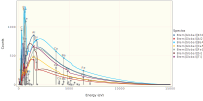

In [3]:
det = matching(unk,132.0, 110)
resp = detectorresponse(det,SDDEfficiency(AP33Model()))

unkb = fittedcontinuum(unk, det, resp)
stdsb = map(s->fittedcontinuum(s, det, resp), stds)

plot(unkb,stdsb...,klms=elems,xmax=15.0e3)


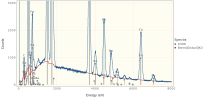

In [4]:
plot(unk,unkb,autoklms=true,xmax=8.0e3, yscale=0.1)

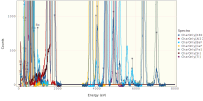

In [5]:
unkc = subtractcontinuum(unk, det, resp)
stdsc = map(s->subtractcontinuum(s, det, resp), stds)
plot(unkc, stdsc..., autoklms=true, xmax=8.0e3, yscale=0.01)

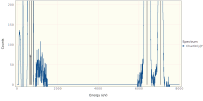

In [6]:
plot(stdsc[4], autoklms=true, xmax=8.0e3, yscale=0.01)

Seems to work - at least the basic concept.

In [7]:
function fit_spectrum(
    spec::Spectrum, 
    refs::Dict{Element, <:Spectrum}, 
    det::EDSDetector,
    resp::AbstractArray{<:Real,2};
    brem::Type{<:NeXLBremsstrahlung} = Castellano2004a,
    mc::Type{<:MatrixCorrection} = Riveros1993,
 )# ::Vector{KRatio}
  cuds = []
  for (elm, ref) in refs
    cmod = ContinuumModel(
         ref[:Composition],
         ref[:BeamEnergy],
         ref[:TakeOffAngle],
         matrixcorrection = mc,
         bremsstrahlung = brem)
    model = resp * map(e -> e > 50.0 ? emitted(cmod, e) : 0.0, energyscale(spec))
    cud = map(NeXLSpectrum.labeledextents(characteristic(elm, alltransitions, 0.001), det, 0.001)) do le
       cxrs, ur = le 
       ( cxrs, ur, ref[ur]-model[ur], ref )
    end
    append!(cuds, cud)  
  end
  ascontiguous = let
    scuds = sort(cuds, lt=(c1,c2)->first(c1[2])<first(c2[2]))
    res = [ scuds[1][2] ]
    for (_, roi, _, _) in scuds[2:end]
      if length(intersect(res[end], roi)) > 0
        res[end] = min(first(roi), first(res[end])):max(last(roi), last(res[end]))
      else
        push!(res, roi)
      end
    end
    res
  end
  cmod = ContinuumModel(
         unk[:Composition],
         unk[:BeamEnergy],
         unk[:TakeOffAngle],
         matrixcorrection = mc,
         bremsstrahlung = brem)
  model = resp * map(e -> e > 50.0 ? emitted(cmod, e) : 0.0, energyscale(spec))
  y = counts(unk) - model
  res = UncertainValues[]
  for roi in ascontiguous
    fcuds = filter(cud->length(intersect(cud[2], roi))>0, cuds)
    a = zeros(Float64, (length(roi), length(fcuds)))
    labels, scales = Label[], Float64[]
    for (i, cud) in enumerate(fcuds)
      (cxrs, croi, cdata, cref) = cud
      a[first(croi)-first(roi)+1:last(croi)-first(roi)+1,i] = cdata
      push!(labels, CharXRayLabel(spec, croi, cxrs))
      push!(scales, dose(cref) / dose(unk))
    end
    push!(res, diagm(scales)*NeXLSpectrum.olspinv(y[roi], a, 1.0, labels))
  end
  return cat(res...)
end

fit_spectrum (generic function with 1 method)

In [8]:
refs = Dict(n"O"=>stds[1],n"Ba"=>stds[2],n"Ca"=>stds[3],n"Fe"=>stds[4],n"Si"=>stds[5],n"Ti"=>stds[6])
fit_spectrum(unk, refs, det, resp)

| Labels                        | Values                        |                               | k[Ti L3-M1 + 6 others, K309]  | k[Fe L3-M5 + 9 others, K309]  | k[O K-L3 + 1 other, K309]     | k[Si K-L3 + 2 others, K309]   | k[Ba L3-M1, K309]             | k[Ca K-L3 + 1 other, K309]    | k[Ca K-M3 + 1 other, K309]    | k[Ti K-L3 + 1 other, K309]    | k[Ti K-M3 + 1 other, K309]    | k[Ba L3-M5 + 17 others, K309] | k[Fe K-L3 + 1 other, K309]    | k[Fe K-M3 + 1 other, K309]    |
| :---------------------------- | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: | :---------------------------: |
| k[Ti L3-M1 + 6 others, K309]  | 2.80e-02                      |                               | (3.16e-05)²                   | 1.67e-12                      | -3.34e-11                     | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[Fe L3-M5 + 9 others, K309]  | 7.80e-02                      |                               | 1.67e-12                      | (9.98e-06)²                   | -5.24e-13                     | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[O K-L3 + 1 other, K309]     | 6.37e-01                      |                               | -3.34e-11                     | -5.24e-13                     | (7.61e-06)²                   | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[Si K-L3 + 2 others, K309]   | 1.41e-01                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | (1.59e-06)²                   | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[Ba L3-M1, K309]             | 4.07e-01                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | (4.90e-04)²                   | -7.61e-12                     | -3.50e-08                     | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[Ca K-L3 + 1 other, K309]    | 2.13e-01                      | ±                             | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | -7.61e-12                     | (7.61e-06)²                   | 1.10e-12                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[Ca K-M3 + 1 other, K309]    | 2.18e-01                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | -3.50e-08                     | 1.10e-12                      | (9.46e-05)²                   | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      |
| k[Ti K-L3 + 1 other, K309]    | 2.84e-04                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | (7.98e-06)²                   | 9.14e-11                      | -1.26e-10                     | 0.00e+00                      | 0.00e+00                      |
| k[Ti K-M3 + 1 other, K309]    | 1.65e-02                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 9.14e-11                      | (4.73e-05)²                   | -3.35e-10                     | 0.00e+00                      | 0.00e+00                      |
| k[Ba L3-M5 + 17 others, K309] | 1.53e-01                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | -1.26e-10                     | -3.35e-10                     | (2.15e-05)²                   | 0.00e+00                      | 0.00e+00                      |
| k[Fe K-L3 + 1 other, K309]    | 9.44e-02                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | (1.16e-05)²                   | 0.00e+00                      |
| k[Fe K-M3 + 1 other, K309]    | 1.28e-01                      |                               | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | 0.00e+00                      | (9.21e-05)²                   |

Let's compare this to the filter-fit result.

In [9]:
ffrs = references( [
        reference(n"O", stds[1]),
        reference(n"Ba", stds[2]),
        reference(n"Ca", stds[3]),
        reference(n"Fe", stds[4]),
        reference(n"Si", stds[5]),
        reference(n"Ti", stds[6])
    ], det)
ffres=NeXLSpectrum.fit_spectrum(unk, ffrs)
asa(DataFrame, ffres)

9×10 DataFrame
 Row │ Spectrum   Feature                        Reference  Start  Stop   K    ⋯
     │ UnknownL…  Referenc…                      String     Int64  Int64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ K309       k[Ba L3-M5 + 27 others, BaF2]  BaF2         847   1329  0.13 ⋯
   2 │ K309       k[Ca K-L3 + 3 others, CaF2]    CaF2         789    940  0.20
   3 │ K309       k[Fe K-L3 + 1 other, Fe]       Fe          1320   1432  0.08
   4 │ K309       k[Fe K-M3 + 3 others, Fe]      Fe          1455   1560  0.09
   5 │ K309       k[Fe L3-M5 + 11 others, Fe]    Fe           192    281  0.05 ⋯
   6 │ K309       k[O K-L3 + 1 other, Al2O3]     Al2O3        174    227  0.63
   7 │ K309       k[Si K-L3 + 2 others, Si]      Si           409    489  0.15
   8 │ K309       k[Ti K-L3 + 3 others, Ti]      Ti           950   1127  0.00
   9 │ K309       k[Ti L3-M1 + 6 others, Ti]     Ti           149    227  0.00 ⋯
                                                               5 columns omitted

Clearly, there is some similarity between the numbers but the agreement is not what I'd like.